In [47]:
import os
from pysmiles import read_smiles
from PIL import Image
import argparse
import sys
import time
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error

import torch
import torch_geometric
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import ResGatedGraphConv, global_max_pool, global_mean_pool, global_add_pool
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU
from torch_geometric.data import Dataset, DataLoader

import deepchem as dc
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

Torch version: 1.7.1+cu110
Cuda available: True
Torch geometric version: 1.7.2


In [48]:
from torch_geometric.data import Dataset, DataLoader

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        #self.data = self.data.iloc[29628:]
        #print(self.data.iloc[-1])
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            f = featurizer.featurize(mol["SMILES"])
            data = f[0].to_pyg_graph()
            data.smiles = mol["SMILES"]
            if not self.test:
                data.y = self._get_label(mol["ST1_GAP(eV)"])
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))
            

    def _get_label(self, label):
        if not self.test:
            label = np.asarray([label])
            return torch.tensor(label, dtype=torch.float32)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data
    
def partition(dataset, args):
    num_total = len(dataset)
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    data_train = DataLoader(dataset[:num_train], batch_size=args.batch, shuffle=args.shuffle)
    data_val = DataLoader(dataset[num_train:num_train + num_val], batch_size=args.batch, shuffle=args.shuffle)
    data_test = DataLoader(dataset[num_total - num_test:], batch_size=args.batch, shuffle=args.shuffle)

    return data_train, data_val, data_test

In [49]:
dataset = MoleculeDataset(root="./data/", filename="new_train.csv")
dataset = dataset.shuffle()
num_total = len(dataset)
num_train = int(num_total * (1 - args.test_size - args.val_size))
num_val = int(num_total * args.val_size)
num_test = int(num_total * args.test_size)

In [50]:
class ResGatedConv(nn.Module):
    def __init__(self, args):
        super(ResGatedConv, self).__init__()
        self.in_dim = args.in_dim
        self.out_dim = args.out_dim
        self.hid_dim = args.hid_dim
    
        self.num_layers = args.n_layers
        self.act = args.act
        self.use_bn = args.use_bn
        self.dropout = nn.Dropout2d(args.dropout)
        self.pool = args.pool
        
        self.layers = nn.ModuleList([])
        self.bns = nn.ModuleList([])
        for i in range(self.num_layers):
            input_dim = self.in_dim if i == 0 else self.hid_dim
            conv = ResGatedGraphConv(input_dim, self.hid_dim)
            self.layers.append(conv)
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        # For graph classification
        #self.fc1 = nn.Linear(self.num_layers * self.hid_dim, self.hid_dim)
        self.fc1 = nn.Linear(self.hid_dim, self.hid_dim // 2)
        self.fc2 = nn.Linear(self.hid_dim // 2, self.out_dim)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for i, layer in enumerate(self.layers):
            x = layer(x, edge_index)
            if self.use_bn:
                x = self.bns[i](x)
            x = self.act(x)
        # Pooling layer
        x = self.pool(x, batch)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [51]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        batch = batch.to(device)
        #list_gap = torch.tensor(batch['y']).to(device).float()
        list_gap = batch['y'].clone().detach().to(device).float()
        list_gap = list_gap.view(-1,1)
                
        model.train()
        optimizer.zero_grad()
        list_pred_gap = model(batch)
        list_pred_gap.require_grad = False
        train_loss = criterion(list_pred_gap, list_gap)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_gap))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            batch = batch.to(device)
            list_gap = batch['y'].clone().detach().to(device).float()
            list_gap = list_gap.view(-1,1)

            model.eval()
            list_pred_gap = model(batch)
            list_pred_gap.require_grad = False
            val_loss = criterion(list_pred_gap, list_gap)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_gap))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        gap_total = list()
        pred_gap_total = list()
        smiles = list()
        for i, batch in enumerate(data_test):
            batch = batch.to(device)
            list_gap = batch['y'].clone().detach().to(device).float()
            list_gap = list_gap.view(-1,1)
            gap_total += list_gap.tolist()
            list_gap = list_gap.view(-1,1)

            list_pred_gap = model(batch)
            pred_gap_total += list_pred_gap.view(-1).tolist()
            smiles += batch.smiles

        mae = mean_absolute_error(gap_total, pred_gap_total)
        std = np.std(np.array(gap_total)-np.array(pred_gap_total))
        
    return mae, std, gap_total, pred_gap_total, smiles

def experiment(dataset, device, bar, args):
    time_start = time.time()
    
    model = ResGatedConv(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.L1Loss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()
    
    data_train, data_val, data_test = partition(dataset, args)

    for epoch in range(args.epoch):
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        scheduler.step()
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    mae, std, gap_total, pred_gap_total, smiles = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.smiles = smiles
    args.gap_total = gap_total
    args.pred_gap_total = pred_gap_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

In [52]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()    
    
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'gap_total', 'pred_gap_total')
    g.map(identity, 'gap_total', 'pred_gap_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()    

# Experiment 1. lr vs n_layers
- 가장 영향을 많이 끼치는 lr과 layer 수를 변경하면서 실험 진행
- lr은 1e-3 ~ 1e-6 으로 변경
- n_layers는 1 ~ 11 까지 변경
- 총 20가지 실험 진행

In [25]:
args.shuffle = True
args.epoch = 50

args.step_size = 10
args.gamma = 0.1

args.batch = 128
args.in_dim = 30
args.out_dim = 1
args.hid_dim = 64
args.act = nn.ReLU()
args.use_bn = True
args.dropout = 0.0
args.pool = global_max_pool
args.optim = 'Adam'
args.l2_coef = 0
args.lr = 0.005
args.n_layers = 4

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

list_lr = [1e-3, 1e-4, 1e-5, 1e-6]
list_n_layers = [1, 3, 5, 7, 9, 11]
#list_lr = [0.001]
var1 = "lr"
var2 = "n_layers"

dict_result = dict()
n_iter = len(list_n_layers)*len(list_lr)*args.epoch*(num_train) + num_val
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_layers in list_n_layers:
        args.lr = lr
        args.n_layers = n_layers
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_layers)
        result = vars(experiment(dataset, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json(f'./results/{var1} vs {var2} ResGatedConv1.JSON', orient='table')

 98%|█████████▊| 28674450/29133034 [3:45:06<02:58, 2569.48it/s]lr:1e-06/n_layers:5 took 644seconds.
30039900it [3:56:56, 2714.64it/s]                              lr:1e-06/n_layers:7 took 710seconds.
31405350it [4:09:53, 2774.16it/s]lr:1e-06/n_layers:9 took 776seconds.
32770582it [4:21:58, 3068.78it/s]lr:1e-06/n_layers:11 took 724seconds.
32770800it [4:21:59, 2084.73it/s]


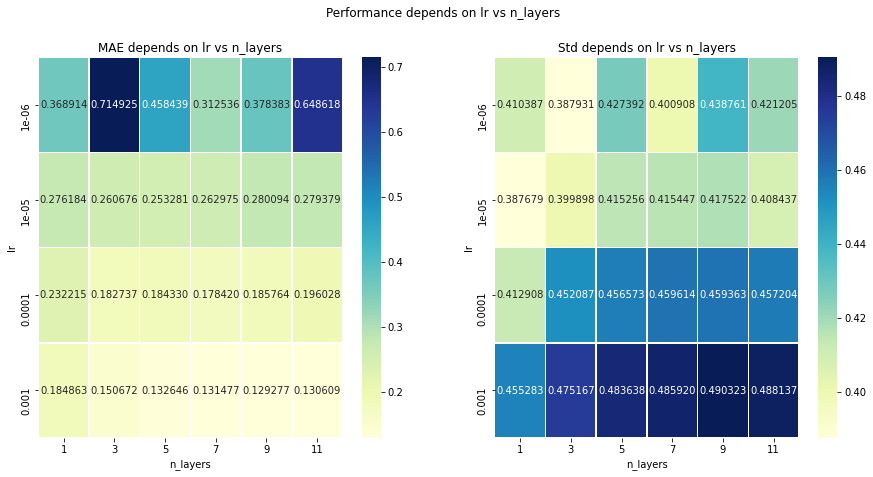

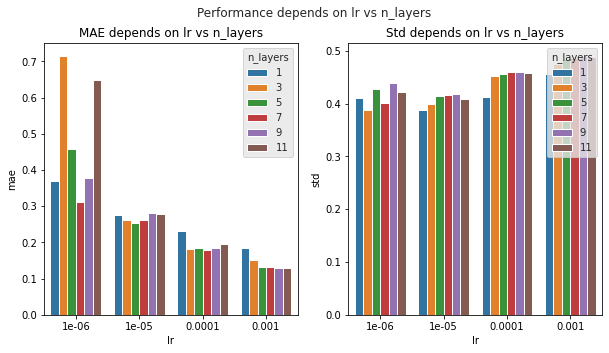

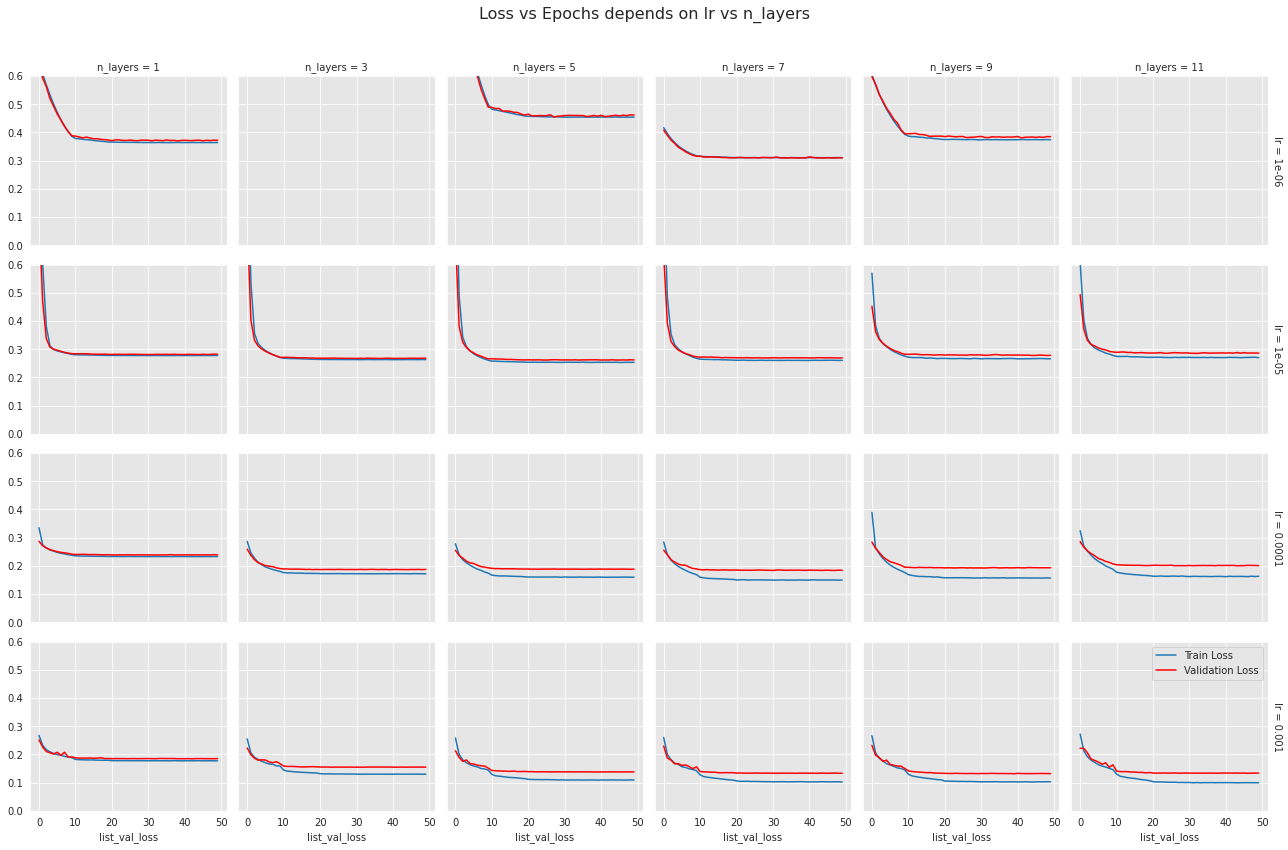

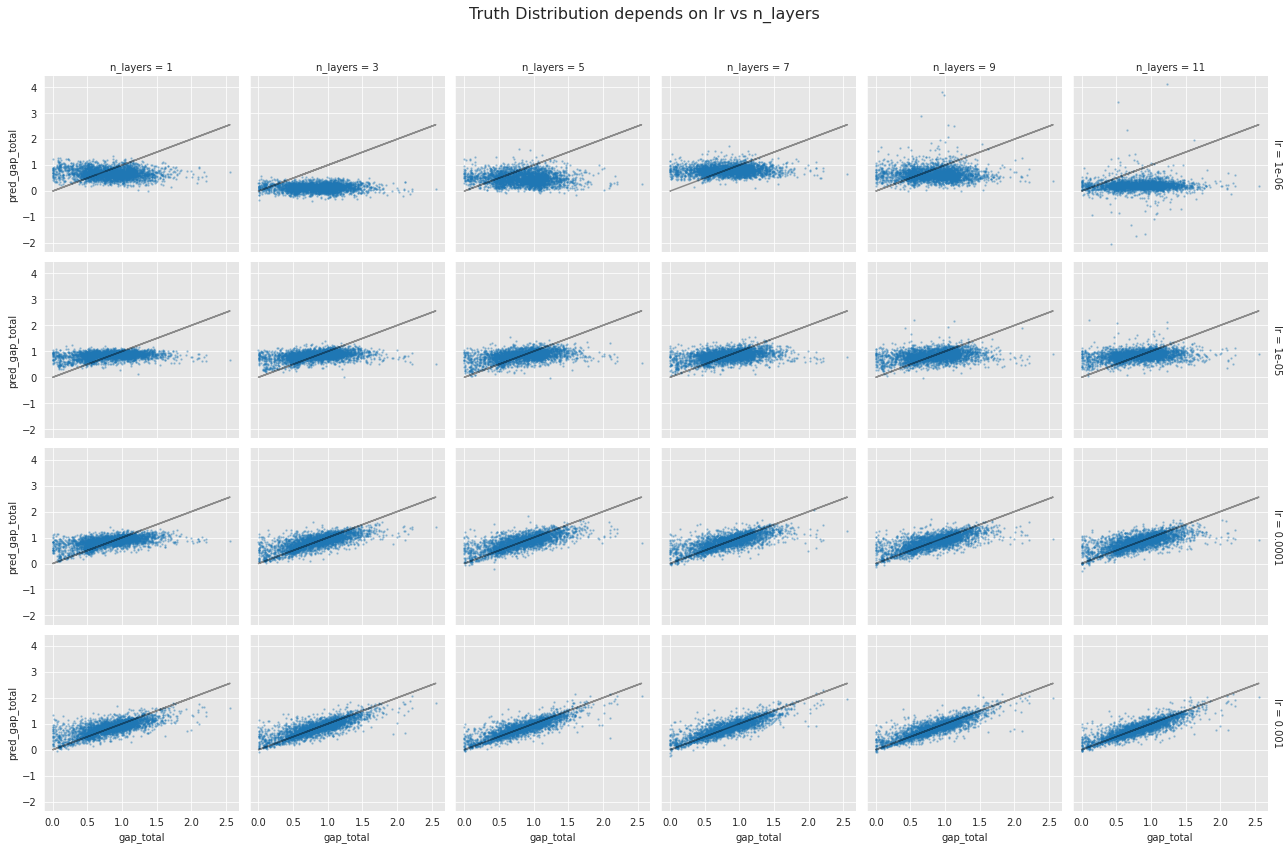

In [26]:
df_result = pd.read_json('./results/lr vs n_layers ResGatedConv1.JSON', orient='table')
plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, ylim=0.6)
plot_distribution(df_result, var1, var2)

## Result(Experiment 1)
- lr = 0.001
- layer = 9


# Experiment 2. hid_dim vs dropout

In [36]:
args.shuffle = True
args.epoch = 40

args.step_size = 10
args.gamma = 0.1

args.batch = 128
args.in_dim = 30
args.out_dim = 1
args.hid_dim = 64
args.act = nn.ReLU()
args.use_bn = True
args.dropout = 0.0
args.pool = global_max_pool
args.optim = 'Adam'
args.l2_coef = 0
args.lr = 0.001
args.n_layers = 9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

list_hid_dim = [32, 64, 256, 512]
list_dropout = [0.0, 0.3, 0.5, 0.7]

#list_lr = [0.001]
var1 = "hid_dim"
var2 = "dropout"

dict_result = dict()
n_iter = len(list_n_layers)*len(list_lr)*args.epoch*(num_train) + num_val
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for hid_dim in list_hid_dim:
    for dropout in list_dropout:
        args.hid_dim = hid_dim
        args.dropout = dropout
        args.exp_name = var1+':'+str(hid_dim)+'/'+var2+':'+str(dropout)
        result = vars(experiment(dataset, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json(f'./results/{var1} vs {var2} ResGatedConv2.JSON', orient='table')

 75%|███████▍  | 17477760/23307034 [2:33:30<51:12, 1897.52it/s]


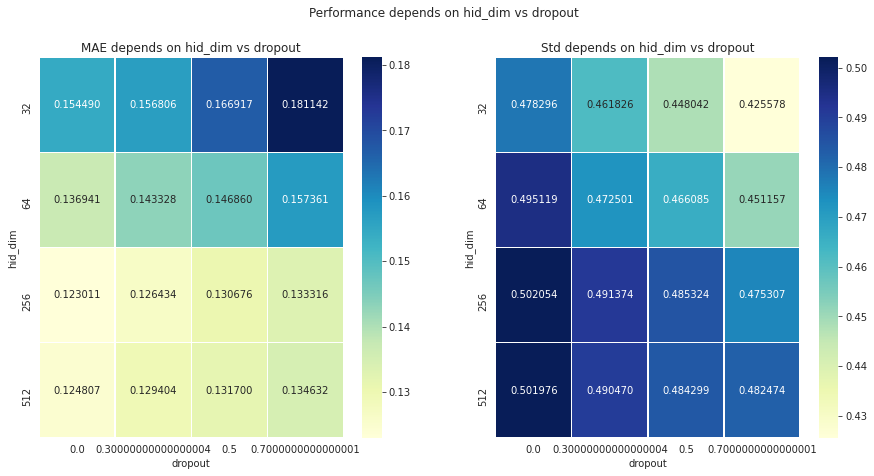

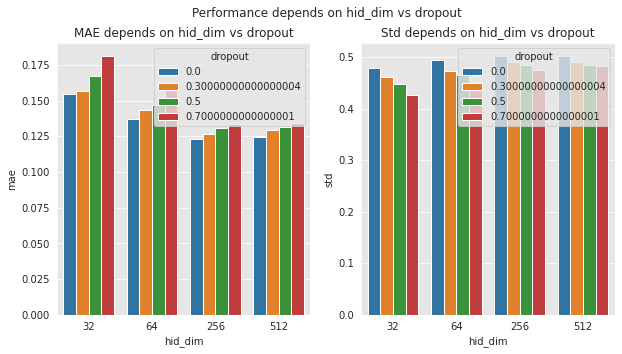

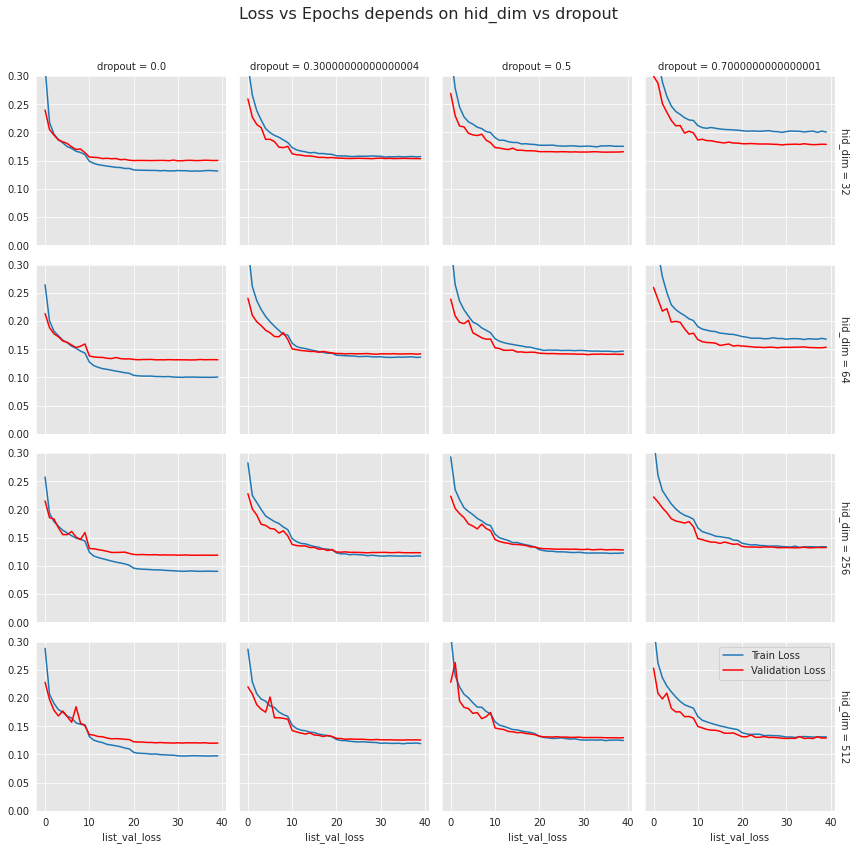

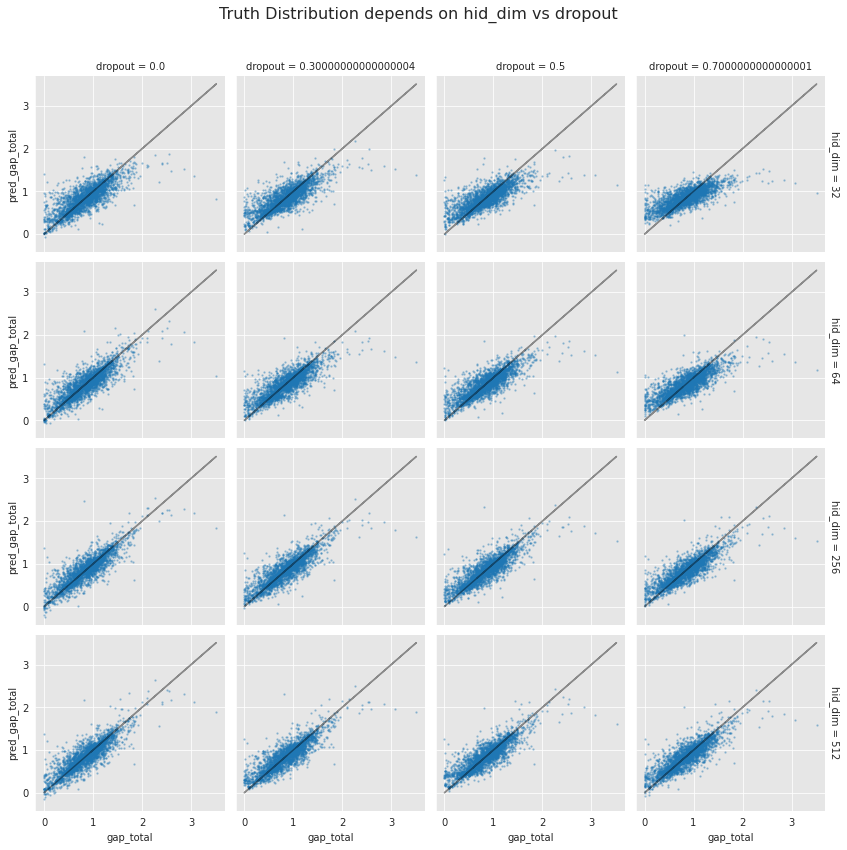

In [41]:
df_result = pd.read_json('./results/hid_dim vs dropout ResGatedConv2.JSON', orient='table')
plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, ylim=0.3)
plot_distribution(df_result, var1, var2)

## Result(Experiment 2)
- hid_dim = 256
- dropout은 0이 좋지만 overfit 해결하려면 적당하게 주면 좋을듯
- lr = 0.001
- layer = 9

# Experiment 3. l2_coef vs dropout

In [59]:
args.shuffle = True
args.epoch = 40

args.step_size = 10
args.gamma = 0.1

args.batch = 128
args.in_dim = 30
args.out_dim = 1
args.hid_dim = 64
args.act = nn.ReLU()
args.use_bn = True
args.dropout = 0.0
args.pool = global_max_pool
args.optim = 'Adam'
args.l2_coef = 0.001
args.lr = 0.001
args.n_layers = 9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

list_l2_coef = [0.01, 0.001, 0.0001, 0]
list_dropout = [0, 0.1, 0.2, 0.3]

#list_lr = [0.001]
var1 = "l2_coef"
var2 = "dropout"

dict_result = dict()
n_iter = len(list_n_layers)*len(list_lr)*args.epoch*(num_train) + num_val
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for l2_coef in list_l2_coef:
    for dropout in list_dropout:
        args.l2_coef = l2_coef
        args.dropout = dropout
        args.exp_name = var1+':'+str(l2_coef)+'/'+var2+':'+str(dropout)
        result = vars(experiment(dataset, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json(f'./results/{var1} vs {var2} ResGatedConv3.JSON', orient='table')

 75%|███████▍  | 17477760/23307034 [2:35:02<51:42, 1878.76it/s]


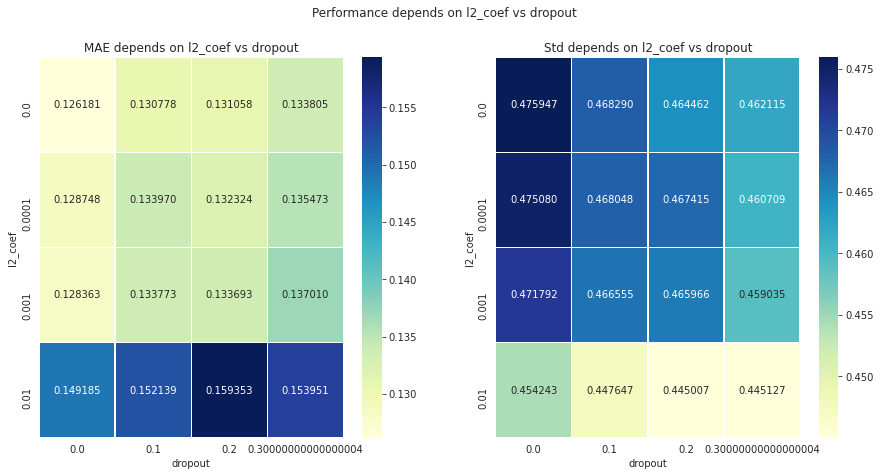

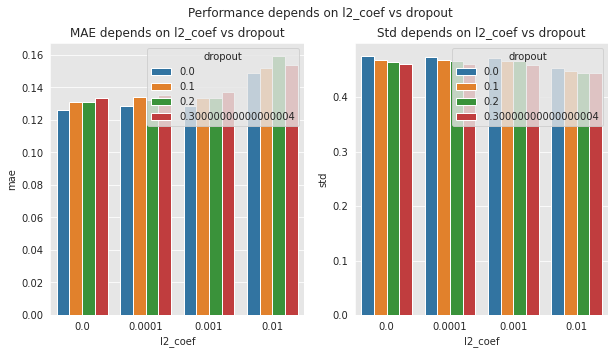

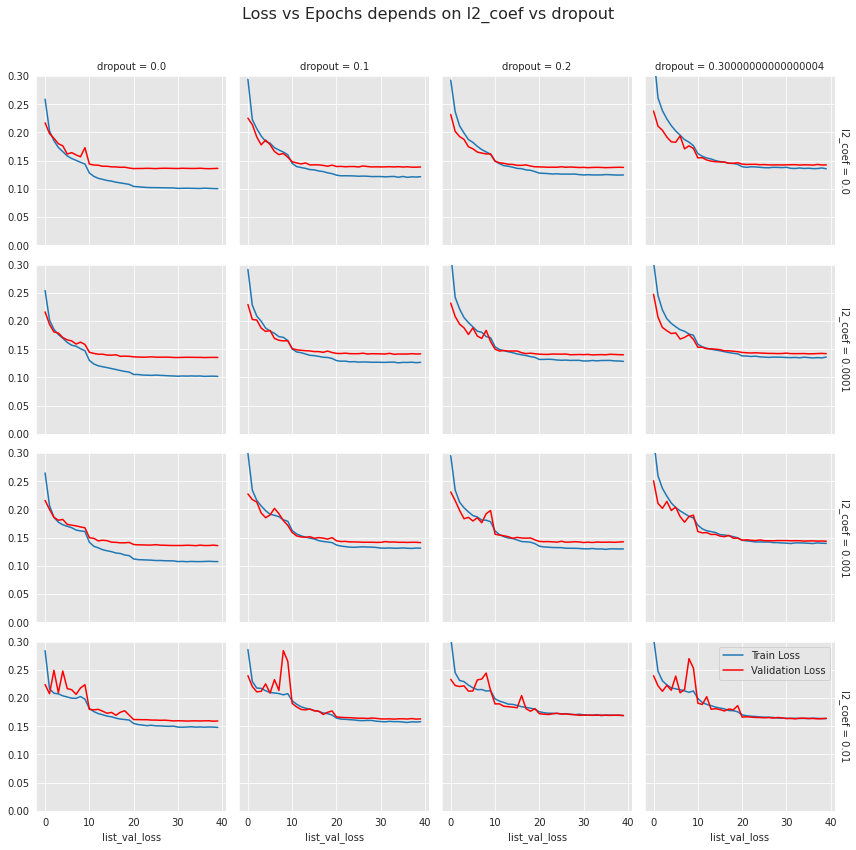

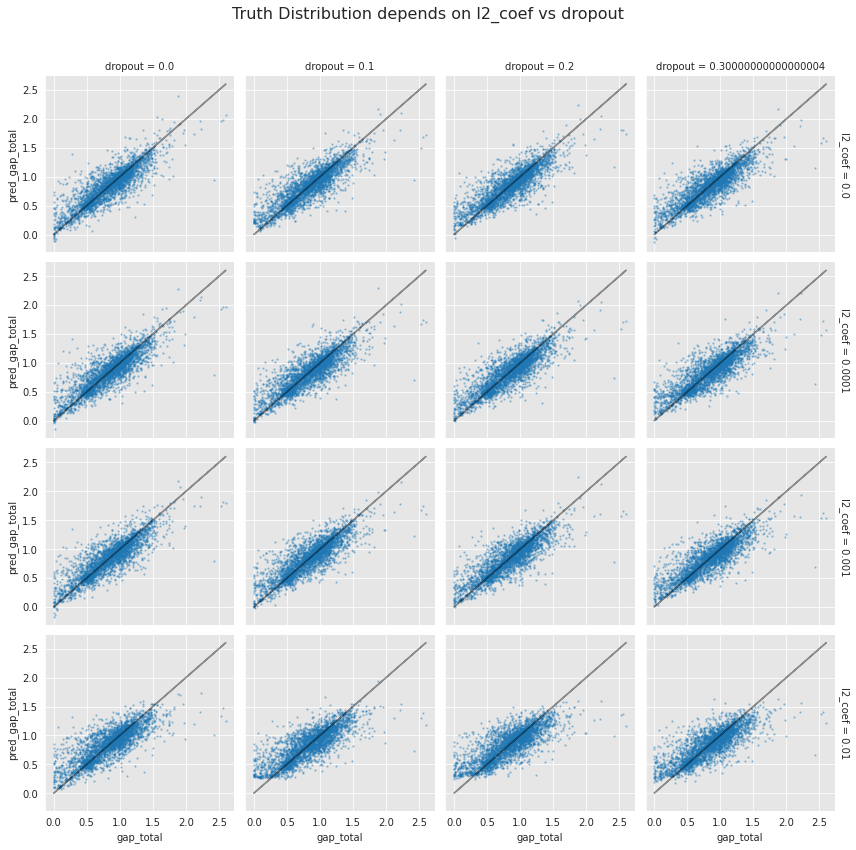

In [60]:
df_result = pd.read_json('./results/l2_coef vs dropout ResGatedConv3.JSON', orient='table')
df_result['mae']
plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, ylim=0.3)
plot_distribution(df_result, var1, var2)

## Result(Experiment3)
- dropout = 0
- l2_coef = 0
- lr = 0.001
- layer = 9
- hid_dim = 256

# Experiment 4. act vs batch

In [61]:
args.shuffle = True
args.epoch = 40

args.step_size = 10
args.gamma = 0.1

args.batch = 128
args.in_dim = 30
args.out_dim = 1
args.hid_dim = 256
args.act = nn.ReLU()
args.use_bn = True
args.dropout = 0.0
args.pool = global_max_pool
args.optim = 'Adam'
args.l2_coef = 0.0
args.lr = 0.001
args.n_layers = 9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

list_act = {'relu': nn.ReLU(), 'silu': nn.SiLU(), 'leaky' : nn.LeakyReLU(), 'selu' : nn.SELU()}
list_batch = [32, 64, 128, 256, 512]

#list_lr = [0.001]
var1 = "act"
var2 = "batch"

dict_result = dict()
n_iter = len(list_act)*len(list_batch)*args.epoch*(num_train) + num_val
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for act in list_act:
    for batch in list_batch:
        args.act = list_act[act]
        args.dropout = dropout
        args.exp_name = var1+':'+str(act)+'/'+var2+':'+str(batch)
        result = vars(experiment(dataset, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json(f'./results/{var1} vs {var2} ResGatedConv4.JSON', orient='table')

 96%|█████████▌| 18570030/19423034 [2:25:17<04:01, 3536.80it/s]act:selu/batch:64 took 531seconds.
19662134it [2:34:06, 3334.51it/s]                              act:selu/batch:128 took 529seconds.
20754622it [2:42:44, 3730.30it/s]act:selu/batch:256 took 517seconds.
21847200it [2:51:28, 3620.72it/s]act:selu/batch:512 took 524seconds.
21847200it [2:51:29, 2123.20it/s]


In [ ]:
df_result = pd.read_json('./results/act vs batch ResGatedConv4.JSON', orient='table')
df_result.sort_values('mae', ascending=True).iloc[0]

## Result(Ex 4)
- dropout = 0
- l2_coef = 0
- lr = 0.001
- layer = 9
- hid_dim = 256
- act = silu
- batch = 512

# Experiment 5. batch vs layer

In [ ]:
args.shuffle = True
args.epoch = 40

args.step_size = 10
args.gamma = 0.1

args.batch = 128
args.in_dim = 30
args.out_dim = 1
args.hid_dim = 256
args.act = nn.SiLU()
args.use_bn = True
args.dropout = 0.0
args.pool = global_max_pool
args.optim = 'Adam'
args.l2_coef = 0.0
args.lr = 0.001
args.n_layers = 9

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

list_n_layers = [9, 11, 13]
list_batch = [512, 600, 800, 1024]

var1 = "n_layers"
var2 = "batch"

dict_result = dict()
n_iter = len(list_n_layers)*len(list_batch)*args.epoch*(num_train) + num_val
bar = tqdm(total=n_iter, file=sys.stdout, position=0)

for n_layers in list_n_layers:
    for batch in list_batch:
        args.n_layers = n_layers
        args.batch = batch
        args.exp_name = var1+':'+str(n_layers)+'/'+var2+':'+str(batch)
        result = vars(experiment(dataset, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json(f'./results/{var1} vs {var2} ResGatedConv5.JSON', orient='table')

 31%|███       | 3621172/11655034 [16:36<34:48, 3847.25it/s]  